# Building LSGAN in TensorFlow

Implementing LSGAN is same as vanilla GAN expect for the change in the loss function. We will see how to generate images of handwritten digits using LSGAN.

## Import libraries

First, we will import all the necessary libraries:

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import tensorflow as tf

from tensorflow.examples.tutorials.mnist import input_data
tf.logging.set_verbosity(tf.logging.ERROR)

import matplotlib.pyplot as plt
%matplotlib inline

### Read the Dataset

Load our MNIST dataset:

In [2]:
data = input_data.read_data_sets("data/mnist",one_hot=True)

Extracting data/mnist/train-images-idx3-ubyte.gz
Extracting data/mnist/train-labels-idx1-ubyte.gz
Extracting data/mnist/t10k-images-idx3-ubyte.gz
Extracting data/mnist/t10k-labels-idx1-ubyte.gz


## Defining Generator 

Generator $G$ takes the noise $z$ as an input and returns an image. We define the generator as simple three layer feed forward network. 

In [3]:
def generator(z,reuse=None):
    
    with tf.variable_scope('generator',reuse=reuse):
        
        hidden1 = tf.layers.dense(inputs=z,units=128,activation=tf.nn.leaky_relu)
        hidden2 = tf.layers.dense(inputs=hidden1,units=128,activation=tf.nn.leaky_relu)
        output = tf.layers.dense(inputs=hidden2,units=784,activation=tf.nn.tanh)
        
        return output

## Defining Discriminator

We know that discriminator $D$ returns the probability. i.e it will tell us the probability of the given image being real. We define the discriminator also as a simple three layer feed forward network. 

In [4]:
def discriminator(X,reuse=None):
    
    with tf.variable_scope('discriminator',reuse=reuse):
        
        hidden1 = tf.layers.dense(inputs=X,units=128,activation=tf.nn.leaky_relu)
        hidden2 = tf.layers.dense(inputs=hidden1,units=128,activation=tf.nn.leaky_relu)
        logits = tf.layers.dense(inputs=hidden2,units=1)
        output = tf.sigmoid(logits)
        
        return logits

## Define the input placeholders


Now, we define the placeholder for the input $x$ and the noise $z$:

In [5]:
x = tf.placeholder(tf.float32,shape=[None,784])
z = tf.placeholder(tf.float32,shape=[None,100])

## Start the GAN!

First we feed the noise z to the generator and it will output the fake image. i.e $ fake \; x = G(z) $

In [6]:
fake_x = generator(z)

Now, we feed the real image to the discriminator $D(x)$ and get the probabillty of being real:

In [7]:
D_logits_real = discriminator(x) 

Similarly, we feed the fake image to the discirminator $D(z)$ and get the probabillty of it being real:

In [8]:
D_logits_fake = discriminator(fake_x,reuse=True) 

## Computing Loss Function

Now, we will see, how to compute the loss function.



### Discriminator Loss

Discriminator loss is given as:

$L^D =\frac{1}{2} \mathbb{E}_{\boldsymbol{x} \sim p_{\mathrm{data}}(\boldsymbol{x})}\left[(D(\boldsymbol{x})-1)^{2}\right]+\frac{1}{2} \mathbb{E}_{\boldsymbol{z} \sim p_{\boldsymbol{z}}(\boldsymbol{z})}\left[(D(G(\boldsymbol{z})))^{2}\right] $

<br>

First we will implement the first term i.e $\frac{1}{2} \mathbb{E}_{\boldsymbol{x} \sim p_{\mathrm{data}}(\boldsymbol{x})}\left[(D(\boldsymbol{x})-1)^{2}\right]$

In [9]:
D_loss_real = 0.5*tf.reduce_mean(tf.square(D_logits_real-1))

Now, the second term, $\frac{1}{2} \mathbb{E}_{\boldsymbol{z} \sim p_{\boldsymbol{z}}(\boldsymbol{z})}\left[(D(G(\boldsymbol{z})))^{2}\right] $

In [10]:
D_loss_fake = 0.5*tf.reduce_mean(tf.square(D_logits_fake))

The final discriminator loss can be written as:

In [11]:
D_loss = D_loss_real + D_loss_fake

### Generator Loss

Generator loss is given as:

$L^G =\frac{1}{2} \mathbb{E}_{\boldsymbol{z} \sim p_{\boldsymbol{z}}(\boldsymbol{z})}\left[(D(G(\boldsymbol{z}))-1)^{2}\right] $

In [12]:
G_loss = 0.5*tf.reduce_mean(tf.square(D_logits_fake-1))

## Optimizing the Loss


Now we need to optimize our generator and discriminator. So, we collect the parameters of the discriminator and generator as $\theta_D$ and $\theta_G$ respectively. 

In [13]:
training_vars = tf.trainable_variables()

theta_D = [var for var in training_vars if 'discriminator' in var.name]
theta_G = [var for var in training_vars if 'generator' in var.name]

Optimize the loss using adam optimizer:

In [14]:
D_optimizer = tf.train.AdamOptimizer(0.001).minimize(D_loss,var_list = theta_D)
G_optimizer = tf.train.AdamOptimizer(0.001).minimize(G_loss, var_list = theta_G)

## Begin Training 

Define the batch size, number of epochs and start the tensorflow session. 

In [15]:
batch_size = 100
num_epochs = 10000

session = tf.InteractiveSession()
session.run(tf.global_variables_initializer())

### Generate Handwritten Digits

Start the tensorflow session and generate handwritten digits:

Epoch: 0, Discriminator Loss:0.0160291660577, Generator Loss: 0.470727235079


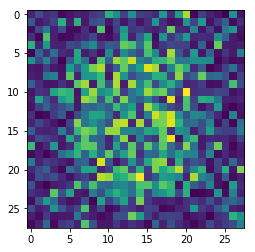

Epoch: 100, Discriminator Loss:0.156552925706, Generator Loss: 0.245793491602


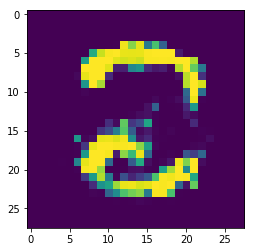

Epoch: 200, Discriminator Loss:0.162407681346, Generator Loss: 0.245565131307


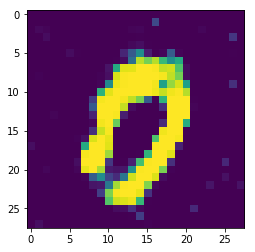

Epoch: 300, Discriminator Loss:0.143970817327, Generator Loss: 0.260525405407


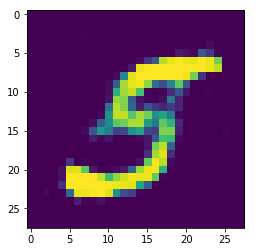

In [ ]:
#for every epcochs
for epoch in range(num_epochs):
    
    #select number of batches
    num_batches = data.train.num_examples // batch_size
    
    #for every batch
    for i in range(num_batches):
        
        #sample batch of data
        batch = data.train.next_batch(batch_size)
        
        #reshape the input images
        batch_images = batch[0].reshape((batch_size,784))
        batch_images = batch_images * 2 - 1
        
        #sample batch of noise
        batch_noise = np.random.uniform(-1,1,size=(batch_size,100))
        
        #define the feed dictionaries with input x as batch_images and noise z as batch noise
        feed_dict = {x: batch_images, z : batch_noise}
    
        #train the discriminator and generator
        _ = session.run(D_optimizer,feed_dict = feed_dict)
        _ = session.run(G_optimizer,feed_dict = feed_dict)

        
    #compute loss of discriminator and generator
    discriminator_loss = D_loss.eval(feed_dict)
    generator_loss = G_loss.eval(feed_dict)
    
    #feed the noise to a generator on every 100th epoch and generate an image
    if epoch%100==0:
        print("Epoch: {}, Discriminator Loss:{}, Generator Loss: {}".format(epoch,discriminator_loss,generator_loss))

        noise = np.random.uniform(-1,1,size=(1,100))
        _fake_x = fake_x.eval(feed_dict ={z:noise})
        
        plt.imshow(_fake_x.reshape(28,28))
        plt.show()
        

We learned that the LSGAN is same as vanilla GAN except that it uses least squares error in its cost function. In the next section, we will learn about WGAN which uses Wasserstein distance in the GAN's loss function.